# Optimización de las transiciones de un sistema de anillos para focalizar luz

**Autor**: Ángela Soria García + Luis Miguel Sánchez Brea

**Fecha**: 11/10/2021

**Objetivo**: Utilizar pyswarm con algún procedimiento de diffractio. En este caso usamos un sistema de anillos.

**Descripción**: 

- Como función objetivo ponemos el foco de una lente stándard. o una delta de dirac
- Ponemos los anillos iniciales como si fuera un axicón.
- optmizamos con pocos puntos, para que no sea demasiado lento.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from diffractio import np, sp, plt
from diffractio import mm, um, nm, degrees

from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.utils_math import nearest


number of processors: 8
total memory        : 15.5 Gb
available memory    : 56 %
max frequency       : 3100 GHz


In [3]:

import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.single.local_best import LocalBestPSO
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
from pyswarms.utils.plotters.formatters import Mesher

## Descripción de la intensidad

In [4]:
def generate_rings_mask(transitions, t_mask, has_draw=False):
    num_rings=len(transitions)
    
    inner_radii = np.zeros(int(num_rings/2))
    outer_radii = np.zeros(int(num_rings/2))

    inner_radii[:]=transitions[0::2]  #Primer argumento: Todas las partículas
    outer_radii[:]=transitions[1::2]
    
    t_mask.rings(r0=(0,0), inner_radius=inner_radii, outer_radius=outer_radii, mask=True)
    t_mask.u = np.exp(1j*np.pi*t_rings.u)
    t_mask.pupil()
    
    if has_draw:
        t_mask.draw('field')
    
    return t_mask

In [5]:
def focus_intensity_rings(transitions, t_mask, has_draw=False):
    
    transitions.sort()
    
    t_mask=generate_rings_mask(transitions, t_mask, has_draw=False)
    
    
    u2=t_rings.RS(z=focal,verbose=False)
    
    if has_draw:
        u2.draw(has_colorbar='vertical', logarithm=False)
    
    
    return u2.intensity()

## Funciones de coste

El número de dimensiones del problema corresponde con el número de transiciones de la red de Damman. El número de órdenes corresponde con los órdenes de difracción de la red.

## Optimization

In [6]:
def cost_function_1(intensity):
    
    return -intensity.max()

In [7]:
def cost_function_2(intensity, intensity_desired):
    
    distance = np.sqrt(((intensity-intensity_desired)**2).mean())/intensity_desired.mean()
    
    return(distance)

In [8]:
def opt_func_1(Transitions, t_mask):
    num_particles = Transitions.shape[0]  # number of particles
    intensidad = [optimization_loop_1(Transitions[i,:],t_mask) for i in range(num_particles)]
    return intensidad


In [9]:
def optimization_loop_1(transitions, t_mask, has_draw=False):

    intensity = focus_intensity_rings(transitions, t_mask, has_draw=False)
    cost1 = cost_function_1(intensity)
    return cost1

In [10]:
def optimization_loop_2(transitions, t_mask, intensity_desired, has_draw=False):

    intensity = focus_intensity_rings(transitions, t_mask, has_draw=False)
    cost1 = cost_function_2(intensity, intensity_desired)
    return cost1

In [11]:
def opt_func_2(Transitions, t_mask, intensity_desired):
    num_particles = Transitions.shape[0]  # number of particles
    intensidad = [optimization_loop_2(Transitions[i,:],t_mask, intensity_desired) for i in range(num_particles)]
    return intensidad

### Otros parámetros a explorar:

In [98]:
def strehl_ratio(I_sample, I_ideal):
    return I_ideal/I_sample

In [99]:
def intensity_max(u, verbose=False):
    intensity_focus=u.intensity()
    intensity_max=intensity_focus.max()
    if verbose:
        print("I_max = {2.2f}".format(intensity_max))
    return intensity_max


In [100]:


def intensity_out(u, radius_out, size=0, mask=None, has_draw=False, verbose=False):
    if size>0:
        u3=u.cut_resample(x_limits=(-size/2,size/2),y_limits=(-size/2,size/2), new_field=True)
    else: 
        u3=u
        size=u.x[-1]
    
    if has_draw:
        u3.draw(logarithm=True)        
        u3.draw_profile([-size,0], [size,0]);

    intensity_focus=u3.intensity()
    intensity_max=intensity_focus.max()        
        
    i_x_max,_,_=nearest(u3.x,0)
    i_y_max,_,_=nearest(u3.y,0)        

    #forma sencilla
    I_optimal=np.zeros_like(u3.u, dtype=float)
    I_optimal[i_y_max,i_x_max]=intensity_max
    mask_size = intensity_focus.size
    
    if mask is None:
        #forma más elaborada
        mask=Scalar_mask_XY(u3.x,u3.y,u3.wavelength)
        mask.circle(r0=(0,0), radius=radius_out)
        mask.inverse_amplitude()
        
    if has_draw:
        mask.draw()
        plt.title('mask')

    mask_size=mask.u.sum()
    error=np.real((mask.u*(intensity_focus-I_optimal)).sum()/mask_size)
    
    if verbose:
        print("error = {:2.2f}".format(error))
    
    return error, mask



## Create example

In [12]:
num_pixels=256
focal=5*mm
wavelength=0.6328
diameter=500*um
x0=np.linspace(-diameter/2,diameter/2,num_pixels)
y0=np.linspace(-diameter/2,diameter/2,num_pixels)

num_transitions_optimal=diameter**2/(4*wavelength*focal)
print("num rings = {}".format(num_transitions_optimal))

t_rings=Scalar_mask_XY(x0,y0,wavelength)


num rings = 19.75347661188369


### Lente estándar de Fresnel


I_max = 1400 con la lente de Fresnel. La lente tiene 20 anillos.


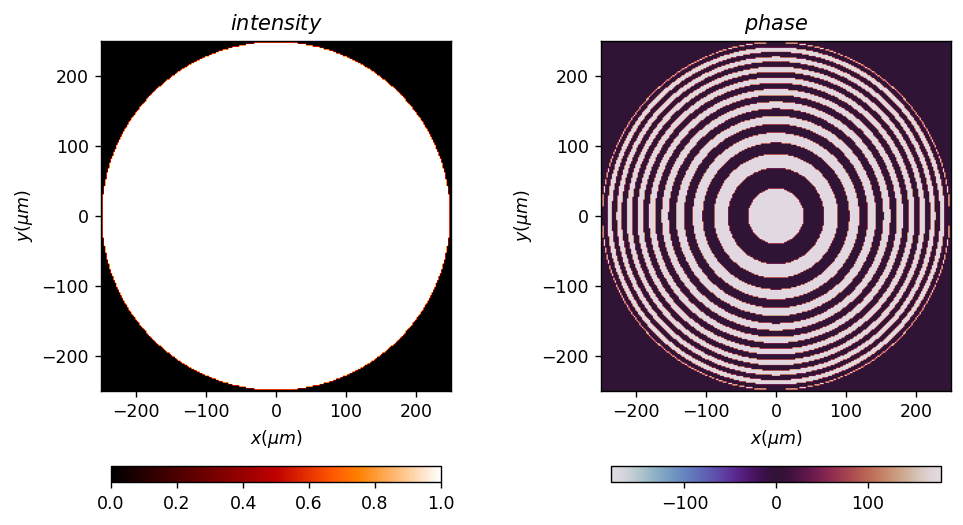

In [13]:
t_lens=Scalar_mask_XY(x0,y0,wavelength)
t_lens.fresnel_lens(r0=(0,0), radius=diameter/2, focal=focal, kind='phase', mask=True)
t_lens.draw('field');

In [14]:
u_fresnel=t_lens.RS(z=focal, verbose=True)

Good result: factor 3.20


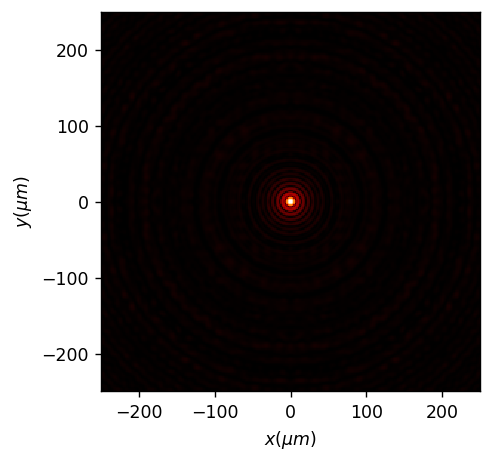

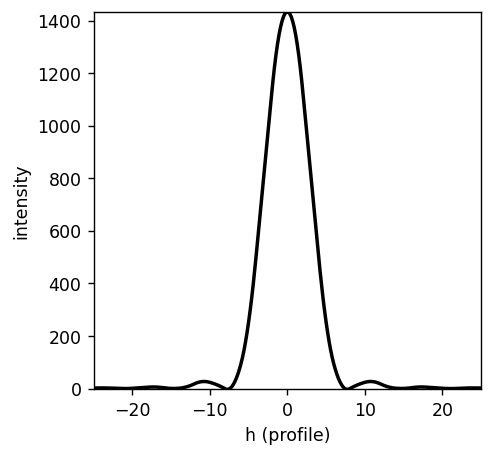

In [15]:
u_fresnel.draw(logarithm=True);
u_fresnel.draw_profile([-25,0], [25,0]);

In [16]:
intensity_fresnel=u_fresnel.intensity()
intensity_fresnel_max=intensity_fresnel.max()

### Ejecución de anilos

In [17]:
radius_max = x0[-1]

transitions=np.linspace(25,radius_max,10)


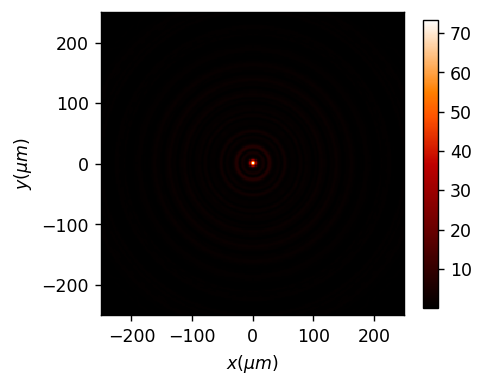

In [18]:
intensity_rings=focus_intensity_rings(transitions, t_rings, has_draw=True);

### Ejecuciones de costes

In [19]:
cost_value1=cost_function_1(intensity_fresnel)
cost_value2=cost_function_2(intensity_fresnel, intensity_fresnel)

print(cost_value1, cost_value2)

-1357.429277080062 0.0


In [20]:
cost_value1=cost_function_1(intensity_rings)
cost_value2=cost_function_2(intensity_rings, intensity_fresnel)

print(cost_value1, cost_value2)

-73.42475147026406 31.924637027462023


# Algorithm

https://pythonhosted.org/pyswarm/

Utilizamos la función GlobalBestPSO de PySwarms para optimizar la función, cuyos argumentos son los siguientes:

- n_particles: # de partículas que el algoritmo utiliza para alcanzar el mínimo.
- dimensions: Las dimensiones corresponde con las trasiciones de nuestra red.
- options: 
   * c1 : float
      cognitive parameter
   * c2 : float
        social parameter
   * w : float
        inertia parameter 
   * 'omega : flaot
       velocity factor
       
- bounds: Restricciones mínima y máxima de las transiciones de la red



In [39]:
num_transitions= 16 #pares
num_iters= 15 # suelen ser más
num_particles = 10 # suelen ser más

In [67]:
min_bound = np.zeros(num_transitions)
max_bound = radius_max*np.ones(num_transitions)
bounds = (min_bound, max_bound)

omega_0 = np.linspace(0.9,0.25,num_transitions)

In [68]:

options = {'c1': 0.5, 'c2': 0.6, 'w': 0.9, 'omega': omega_0}

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=num_transitions, options=options, bounds=bounds)

In [91]:
%%time

kind_optimization=1

if kind_optimization==1:
    cost, transitions_final = optimizer.optimize(opt_func_1, iters=num_iters,  t_mask=t_rings)
elif kind_optimization==2:
    cost, transitions_final = optimizer.optimize(opt_func_2, iters=num_iters,  t_mask=t_rings, intensity_desired=intensity_fresnel)

2021-10-30 23:25:44,960 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 0.5, 'c2': 0.6, 'w': 0.9, 'omega': array([0.9       , 0.85666667, 0.81333333, 0.77      , 0.72666667,
       0.68333333, 0.64      , 0.59666667, 0.55333333, 0.51      ,
       0.46666667, 0.42333333, 0.38      , 0.33666667, 0.29333333,
       0.25      ])}
pyswarms.single.global_best: 100%|██████████|15/15, best_cost=-646
2021-10-30 23:26:09,025 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -645.5578991376769, best pos: [ 17.06259361  47.9388837   47.94825174  64.70904201  84.18868543
 102.93434253 115.68407672 129.34250927 141.40568753 151.80464038
 161.86765485 171.20723968 180.80923431 205.08264141 212.92319116
 234.28687859]


CPU times: user 23.5 s, sys: 540 ms, total: 24.1 s
Wall time: 24.1 s


In [92]:
transitions_final

array([ 17.06259361,  47.9388837 ,  47.94825174,  64.70904201,
        84.18868543, 102.93434253, 115.68407672, 129.34250927,
       141.40568753, 151.80464038, 161.86765485, 171.20723968,
       180.80923431, 205.08264141, 212.92319116, 234.28687859])

<AxesSubplot:title={'center':'Cost History'}, xlabel='Iterations', ylabel='Cost'>

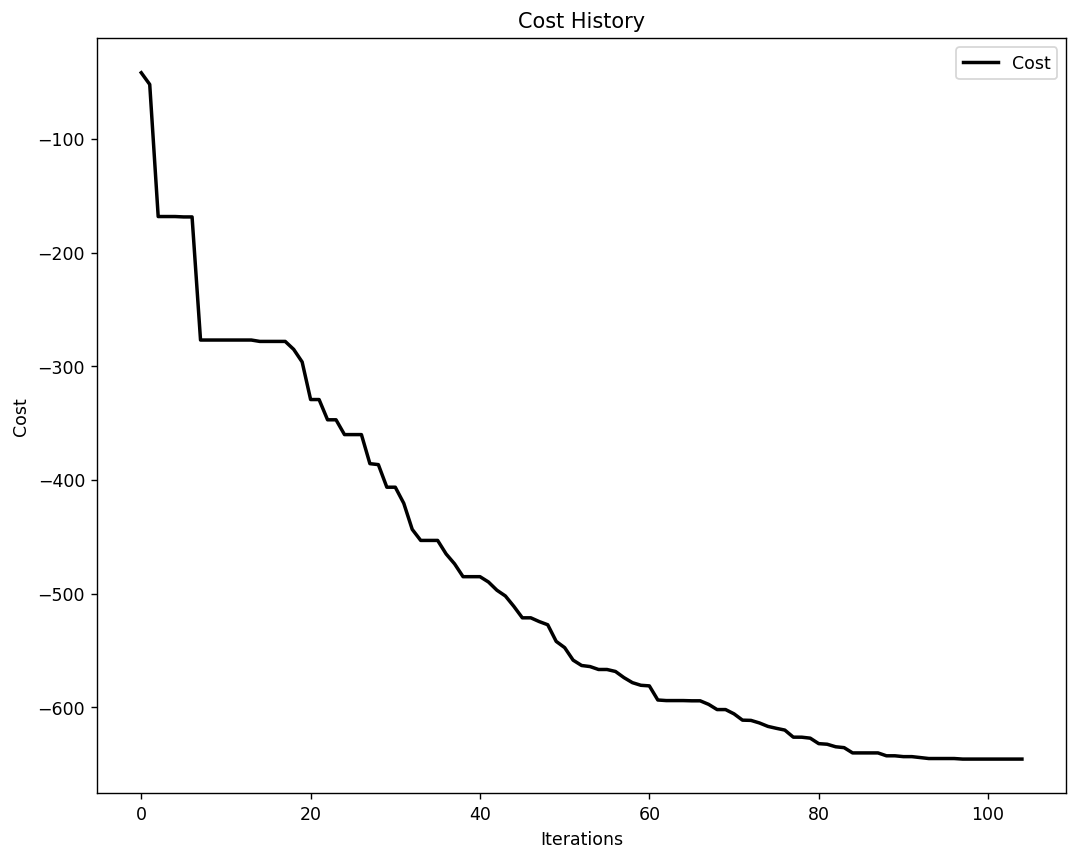

In [93]:
plot_cost_history(cost_history=optimizer.cost_history)

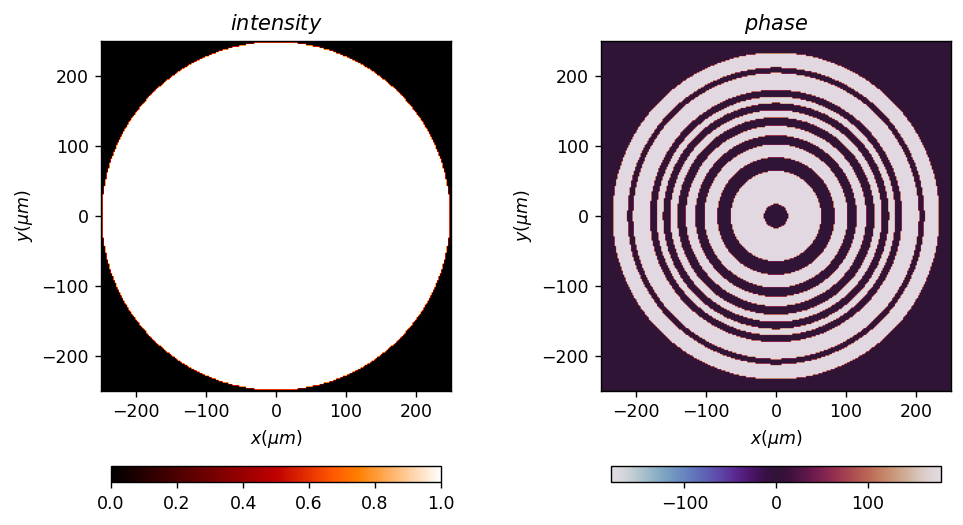

In [94]:
u_final=generate_rings_mask(transitions_final, t_rings, has_draw=True)

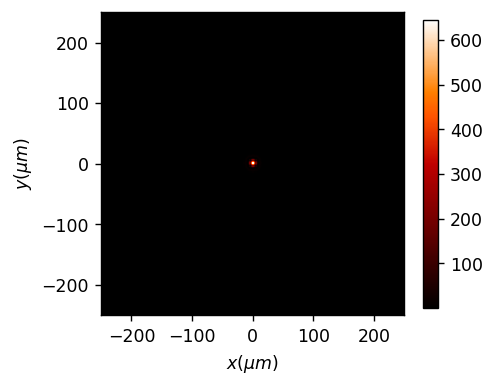

In [95]:
intensity_rings=focus_intensity_rings(transitions_final, t_rings, has_draw=True);

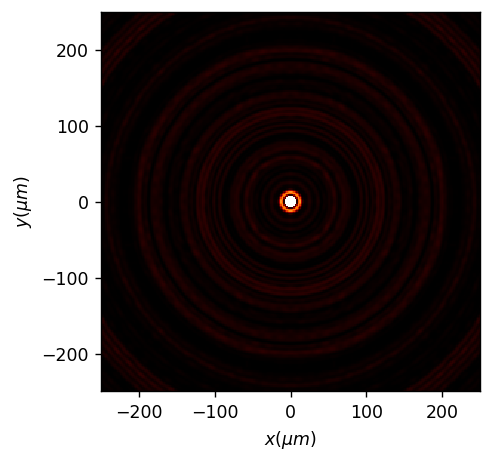

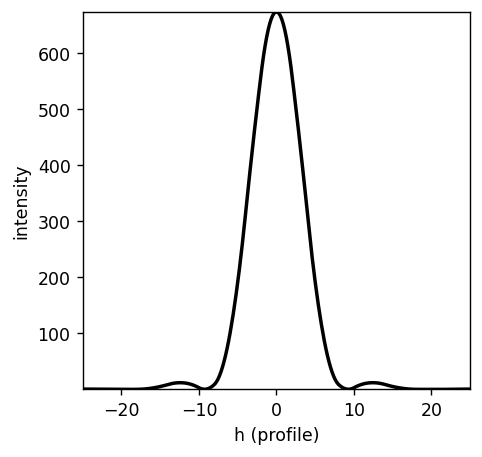

In [96]:
t_rings.u=np.sqrt(intensity_rings)
t_rings.draw(logarithm=1e-1)
t_rings.draw_profile([-25,0], [25,0]);

In [97]:
intensity_final=t_rings.intensity()
intensity_final_max=intensity_final.max()

print("intensity_final_max = {:2.2f}, strehl = {:2.2f}".format(intensity_final_max, intensity_fresnel_max/intensity_final_max))

intensity_final_max = 645.56, strehl = 2.10


## Conclusiones
- d

## Tareas
- Aprender bien PSO y calcular parámetros. ¿cuál es la velocidad?
- Poner límites y evitar transiciones.
- se podrían poner límites de fabricabilidad, es decir si la distancia entre 2 puntos es pequeña, separarla